# A Multiagent transportation system

Auteur : Philippe Mathieu, [CRISTAL Lab](https://www.cristal.univ-lille.fr/), [SMAC Team](https://www.cristal.univ-lille.fr/?rubrique26&id=7), [University of Lille](http://www.univ-lille1.fr), email : philippe.mathieu@univ-lille.fr

Contributeurs : Corwin Fèvre (CRISTAL/SMAC , CRISTAL/OSM)

Creation : 15/01/2020


## Principe général


Cette feuille fait suite à [mas_basics_fr.ipynb](mas_basics_fr.ipynb) qui donnait les bases de la construction d'un système multi-agents sur un reseau social.
Nous vous montrons ici, comment réaliser une petite simulation d'un système de co-voiturage à l'aide des agents.

## Un système séquentiel

Dans sa forme la plus simple, un agent est une entité dotée d'une seule
capacité, celle de décider quoi faire. Personne ne lui indique ce qu'il doit faire,
c'est lui qui décide ! C'est le principe d'**autonomie**. Il suffit juste de lui donner la
parole pour qu'il agisse. Lors de sa prise de parole, l'agent réalise sémantiquement 3 étapes différentes : la **perception** de son entourage, la **decision** en fonction de son propre état et de ce qu'il a perçu, puis l'**action** effective qu'il réalise in fine. Idéalement chaque agent ne peut faire qu'une seule action lors de sa prise de parole.

In [ ]:
class Agent:
      def __init__(self,name) :
          self.name=name
        
      def decide(self):
          print("Bonjour ! My name is "+self.name)

Il est bien sûr possible de créer plusieurs agents et de les interroger directement.

In [ ]:
a1 = Agent("philippe")
a2 = Agent("corwin")
a1.decide()
a2.decide()

### Le système multiagent séquentiel

Bien évidemment, un système multi-agent utilise des dizaines voire des
milliers d'agents. Il est alors necessaire de créer une classe
permettant de les manager. En général la méthode qui lance la
simulation se nomme `run` et prend en paramètre le nombre de prises de
paroles.
Afin d'assurer le principe d'**équité** on s'assure que chaque agent a
au moins une fois la parole avant qu'un autre agent ne l'ait deux
fois. On s'appuie pour cela sur la notion de tour de parole. Chaque tour de
parole donne aléatoirement la parole à l'ensemble des agents, avant de
recommencer. Un tour de parole constitue sémantiquement une unité de temps, un tick d'horloge. La classe SMA s'écrit :


In [ ]:
import random
class SMA:
      def __init__(self):
        self.tick=0
        self.resetTicks()
        self.agentList = []

      def resetTicks(self):
          tick=0
          
      def addAgent(self,ag):
          self.agentList.append(ag)
 
      def run(self,rounds):
          for i in range(0,rounds):
              self.runOnce()

      def runOnce(self):
          self.tick+=1
          random.shuffle(self.agentList)
          for ag in self.agentList :
              ag.decide()
          print("tick "+str(self.tick)+" ended")

In [ ]:
sma = SMA()
sma.addAgent(Agent("paul"))
sma.addAgent(Agent("kim"))
sma.run(6)

### La simultanéïté

Le système séquentiel présenté précédemment possède des avantages mais aussi des inconvénients. Parmi ses avanatages, il y a bien évidemment sa simplicité. Il possède néanmoins un inconvénient lié au fait que comme un agent agit dès qu'il le peut (dans sa méthode `decide`), deux agents évalués consécutivement ne sont donc pas face au même état de l'environnement.

Prenons un simple exemple d'agents qui raisonnent sur le nombre d'appels total qu'il y a eu à une des méthodes `decide`. Chacun incrémente ce nombre d'appel global, mais aucun d'entre eux ne perçoit la même valeur.


In [ ]:
global_calls = 0

class Agent:
    def __init__(self,name) :
        self.name=name
            
    def decide(self):
        global global_calls
        global_calls += 1
        print("Je suis ",self.name, "et je pense que le nombre global est ", global_calls) 

sma = SMA()
sma.addAgent(Agent("Paul"))
sma.addAgent(Agent("Kim"))
sma.addAgent(Agent("Lisa"))
sma.run(6)

On voir clairement ici la différence de niveau d'information des différents agents au sein d'un même tour de parole.

Dans certaines simulations, il est parfois necessaire que, dans un même tour de parole, tous les agents soient face à la même connaissance lors de leur raisonnement. C'est le principe d'équité en raisonnement, ou en d'autres termes, *la simultanéïté* dans l'action (problème similaire à celui des automates cellulaires : dans le célèbre `jeu de la vie`, toutes les cellules changent d'état simultanément).

Pour implémenter ce principe de simultanéité, le principe perception-decision-action doit être "ventilé". L'agent a alors besoin de 2 méthodes d'accès. La première pour la perception et la décision : `update`  et la seconde pour l'action :`decide`.
Le SMA appelle alors `update` chez tous les agents, puis `decide`. La connaissance étant identique pour tous au moment du raisonnement, l'ordre de passage des agents est maintenant indifférent : ils peuvent tous agir dans le même ordre.

In [ ]:
global_calls = 0 

class Agent:
    def __init__(self,name) :
        self.name=name

    def update(self) :
        global global_calls 
        global_calls += 1
        
    def decide(self):
        print("Je suis ",self.name, "et je pense que le nombre global est ", global_calls)

In [ ]:
import random
class SMA:
    def __init__(self):
        self.tick=0
        self.resetTicks()
        self.agentList = []

    def resetTicks(self):
        tick=0
          
    def addAgent(self,ag):
        self.agentList.append(ag)
 
    def run(self,rounds):
        for i in range(0,rounds):
            self.runOnce()

    def runOnce(self):
        self.tick+=1
        for ag in self.agentList :
            ag.update()
        for ag in self.agentList :
            ag.decide()            
        print("tick "+str(self.tick)+" ended")

In [ ]:
sma = SMA()
sma.addAgent(Agent("Paul"))
sma.addAgent(Agent("Kim"))
sma.addAgent(Agent("Lisa"))
sma.run(3)

Cette fois on constate que tous les agents ont eu la même information dans un même tour de parole.

La simultanéïté des agents résoud parfois certains problèmes, mais elle possède évidemment un inconvénient majeur. Si les ressources accédées par les agents sont communes, il y a alors risque de conflit, et il faudra alors régler les conflits. C'est pourquoi le principe de simultanéïté n'est utilisé dans les SMA que lorsque c'est vraiment necessaire.

Quand des agents `véhicules` circulent sur infrastructure, le SMA leur permet régulièrement d'avancer en fonction de ce qu'ils perçoivent. Dans un tel cas, on comprend aisément que l'ordre de raisonnement des agents devient capital : Si A est devant B et que tous deux sont très proches et à la même vitesse, si A avance en premier, B n'a ensuite aucune difficulté à avancer, tandis que si B avance en premier, l'accident est inévitable. la simultanéïté devient alors impérative.



# La simulation du trafic

A chaque étape, le véhicule suit son itinéraire.

In [1]:
import networkx as nx
import random as random
import matplotlib.pyplot as plt
import itertools

In [2]:
class Agent:
    def __init__(self, unique_id):
        self.is_alive = True
        self.unique_id = unique_id
        self.is_alive = True
    
    def update(self) -> None:
        pass
    
    def decide(self) -> None:
        pass

In [3]:
class DriverAgent(Agent):
    def __init__(self, unique_id, trip):
        super().__init__(unique_id)
        self.trip = trip
        
    def to_string(self):
        print("I am driver",self.unique_id,"- trip:",self.trip)
        
        
    def update(self) :
        pass
    def decide(self) :
        if len(self.trip)>0:
            self.trip.pop(0)
        else :
            self.is_alive = False
            print("Driver",self.unique_id,"arrived")
            

In [104]:
class RiderAgent(Agent):
    def __init__(self, unique_id, v_dep, v_arr):
        super().__init__(unique_id)
        self.v_dep = v_dep
        self.v_r = v_dep
        self.v_arr = v_arr
        self.Av = {self.v_r}
        self.Ats = dict()
        self.Ats[self.v_r]={'distance':0}
        self.Ad = []
        self.G_ts = None
        self.wt = 0
        
    def to_string(self):
        print("I am rider",self.unique_id,"- dep:",self.v_dep,", arr:",self.v_arr)
        
        
    def generate_transition_graph(self):
        G= nx.MultiDiGraph()
        #print(self.Ats)
        G.add_node(self.v_r, distance=0)
        for ats, val in self.Ats.items():
            #print(ats, val)
            #print(ats)
            #print(G_ts.nodes())
            if ats in self.Ad.keys():
                 #G_ts.add_node(ats, distance=val['distance'])
                for ad in self.Ad[ats]:
                    #print("coucou")
                    #si le parcours est faisable
                    #print(ad)
                    d_time_left = ad[2]
                    r_time_left = self.Ats[ats]['distance']
                    d_trip = ad[1]
                    if d_time_left >= r_time_left :
                        if not (G.has_node(ats)):
                            G.add_node(ats, distance=val['distance'])
                        
                        if self.v_arr in ad[1]:
                            new_node = self.v_arr
                            d_subtrip_size = d_trip.index(self.v_arr)
                            #dist = d_time_left + d_subtrip_size
                        else :
                            new_node = ad[1][-1]
                            d_subtrip_size = len(ad[1]) - 1
                            #id_d = ad[0]
                            #TODO il manque qqchose, car si on se base sur le noeuds le plus eloigné il se peut que la contrib soit neg
                            #alors qu'au final il peut quand meme nous faire gagner qqchose.
                            

                        #dist : nombres de ticks minimum necessaires pour atteindre un noeuds
                        
                        dist = d_time_left + d_subtrip_size
                        
                        #dist = ((d_time_left + r_time_left) - (d_time_left - r_time_left)) + d_subtrip_size
                        
                        if G.has_node(new_node):
                            if (dist < G.nodes[new_node]['distance']):
                                G.nodes[new_node]['distance'] = dist
                        else :
                            G.add_node(new_node, distance=dist)
                        
                        
                        contrib = nx.shortest_path_length(sma.graph, source=ats, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=new_node, target=self.v_arr)
                        delay = d_time_left - r_time_left
                        G.add_edge(ats, new_node, d=ad, contrib=contrib, delay=delay)
                    
        self.G_ts = G
    
                    
    def best_driver_contrib_and_wait(self):
        scores_paths = dict()
        cur_node = self.v_r
        #print(cur_node)
        other_nodes = [node for node in list(self.G_ts.nodes()) if node != cur_node]
        paths = nx.all_simple_paths(self.G_ts, source=cur_node, target=other_nodes)

        #heuristique : suivre le chemin qui rapporte le plus de cases le plus rapidement possible
        for path in paths :
            id_d = None
            score_path = 0
            #print(path)
            for i in range(len(path)):

                if i+1<len(path):
                    data = self.G_ts.get_edge_data(path[i], path[i+1])
                    #print(data)

                    #si il y a plusieurs arretes menants au meme noeuds

                    best_score = None
                    #on est dans un multigraph, donc on prends la meilleur edge
                    for j in range(len(data)):
                        cur_score = data[j]['contrib'] - data[j]['delay']
                        if best_score == None or best_score < cur_score:
                            best_score = cur_score
                            if i==0 :
                                id_d = data[j]['d'][0]

                    score_path += best_score                   

                else :
                    break

            scores_paths[id_d]=score_path
        bests_d = [key for m in [max(scores_paths.values())] for key,val in scores_paths.items() if val == m]
        random.shuffle(bests_d)
        #print(bests_d)
        
        for d in self.Ad[cur_node]:
            if d[0] in bests_d and d[2] == 0:
                return(d)
            
        #print("Problème ou meilleur conducteur a venir? Pas de conducteur trouvé")
        return None

    
    
    
    
        
    def update(self):
        self.Ad = sma.get_rider_matched_drivers(self.Ats)
        self.generate_transition_graph()
        
        cur_node = self.v_r
        
        blacklist = set()
        #decision ici:
        
        
        #si véhicule présent direct alors on effectue heuritique sinon reste sur son noeud et comportement dif
        #manque un if ici
        
        #if len([edge for edge in G_ts.out_edges(cur_node) if edge['d'][2]==0]) > 0:
        if len(self.Ad[cur_node]) > 0 and len([driver for driver in self.Ad[cur_node] if driver[2]==0])>0:
            best_driver = self.best_driver_contrib_and_wait()
            #v_r = nouveau noeuds
            #après decision
            if best_driver != None :
                
                new_node = best_driver[1][1]
                #print("new_node",new_node)
                #cur_node = new_node
                print("Agent rider",self.unique_id,"move from",self.v_r,"to",new_node,"using car",best_driver)
                if new_node == self.v_arr:
                    print("Rider n°",self.unique_id,"arrived with a waiting time of",self.wt,"ticks")
                    self.is_alive = False
                    return
                #on ecrase l'ancien noeud
                nx.relabel_nodes(self.G_ts, {cur_node:new_node}, copy=False)
                #G_ts.node[new_node] = G_ts[cur_node]
                #print(G_ts.node[new_node])
                #G_ts.add_edge(new_node, best_driver[1][-1])
                #G_ts.remove_node(cur_node)

                blacklist = set(cur_node)
            else : 
                print("Agent rider",self.unique_id,"doesn't move")
                new_node = cur_node
                self.wt += 1
            
            
        else:
            print("Agent rider",self.unique_id,"doesn't move")
            new_node = cur_node
            self.wt += 1
        
        
        Av = {new_node}
        self.Ats = dict()
        self.Ats[new_node] = {'distance':0}
        #print("nodes in G_ts",self.G_ts.nodes())
        other_nodes = [node for node in list(self.G_ts.nodes()) if node != new_node]
        #print("other_nodes:",other_nodes)
        for node in other_nodes:
            #print("haspath_test between:",new_node,node)
            if nx.has_path(self.G_ts,new_node,node):
                self.G_ts.node[node]['distance'] = self.G_ts.node[node]['distance'] - 1
                self.Ats[node] = {'distance': self.G_ts.node[node]['distance']}
                bl_node = nx.shortest_path(self.G_ts, new_node, node)[-2]
                edge_data = self.G_ts.get_edge_data(bl_node,node)
                #print(data)

                    #si il y a plusieurs arretes menants au meme noeuds
                    #on est dans un multigraph, donc on prends la meilleur edge
                #print("recup noeuds possibles, show edge",edge_data)
                for j in range(len(edge_data)): 
                   
                    d = edge_data[j]['d']
                    self.Av.union(set(d[1]))

            else :
                blacklist.add(node)
                self.G_ts.remove_node(node)

            #clean
            #self.G_ts.remove_node(cur_node)
        
        self.v_r = new_node
        self.Av.difference(blacklist)
        #print(self.Ats)
        
    def decide(self):
        pass

In [110]:
class SMA:
    def __init__(self, agentList, graph):
        self.tick = 0
        self.agentList = agentList
        self.drivers_nodes_tracker = dict()
        self.graph = graph
        self.wt_collector = []
    
    #ces méthodes ne doivent pas être là mais je ne sais pas ou les mettre autrement, ça permet d'éviter
    #de faire plein de demande de match au drivers, on regarde une fois qui match avec quoi avec update_nodes_tracker
    #puis ensuite il suffit d'acceder au dictionnaire avec get_rider_matched_drivers
    
    
    def update_nodes_tracker(self):
        drivers = [agent for agent in self.agentList if (agent.__class__.__name__ == "DriverAgent")]
        
        for node in list(self.graph.nodes()):
            self.drivers_nodes_tracker[node] = list()
            
        for key in list(self.drivers_nodes_tracker.keys()):
            for driver in drivers :   
                if key in driver.trip:
                    m_idx = driver.trip.index(key)
                    sub_trip = driver.trip[m_idx:]
                    #on verifie que le noeud de transition n'est pas l'arrive du conducteur
                    if len(sub_trip) > 1:
                        self.drivers_nodes_tracker[key].append((driver.unique_id, driver.trip[m_idx:], m_idx))
        #print("\n driver node tracker :", self.drivers_nodes_tracker)
        
        
    def get_rider_matched_drivers(self, Av):
        Ad = dict()
        for av in Av:
            Ad[av] = self.drivers_nodes_tracker[av]
        
        #print("\n ad :", Ad)
        return Ad
        
        
    def run(self, rounds):
        for i in range(0,rounds):
            self.runOnce()

    def runOnce(self):
        self.tick += 1
        
        #on nettoie la liste des agents
        for a in agentList :
            if a.is_alive == False:
                if a.__class__.__name__ == "RiderAgent":
                    self.wt_collector.append(a.wt)
                agentList.remove(a) 
            
        self.update_nodes_tracker()
        for agent in self.agentList:
            agent.update()
            agent.decide()
        print("tick " + str(self.tick) + " ended")

/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


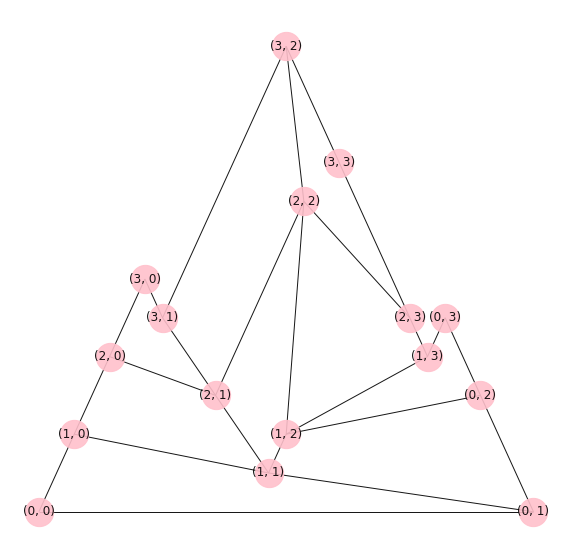

In [111]:
graph = nx.grid_2d_graph(4,4)


plt.figure(figsize=(10,10))    # pour définir la taille de la figure
pos = nx.planar_layout(graph)
nx.draw_networkx(graph,pos=pos,edge_color='black',width=1,linewidths=1,node_size=800,node_color='pink',alpha=0.9)
plt.axis('off')
plt.show()


In [112]:
nx.shortest_path(graph,(1,1), (1,2))[-2]

(1, 1)

In [113]:
# node_list = list(graph.nodes)
# trip1 = nx.shortest_path( graph, random.choice(node_list), random.choice(node_list))
# trip2 = nx.shortest_path( graph, (1, 3), (1, 0))
# print(trip2)
# trip3 = nx.shortest_path( graph, (1, 0), (2, 3))
# trip4 = list(((2,2),(1,2),(0,2),(1,1)))
# trip5 = list(((3,2),(2,2),(2,3),(1,3),(0,3),(0,2)))
# print("\n trip1:",trip1,"\n trip2:",trip2,"\n trip3:",trip3,"\n trip4:",trip4, "\n trip5:",trip5 )

In [114]:
#agentList = [RiderAgent(0,(1, 1),(1, 3)),RiderAgent(6,(2, 2),(2, 3)), DriverAgent(1, trip1), DriverAgent(2, trip2), DriverAgent(3, trip3), DriverAgent(4, trip4), DriverAgent(5, trip5)]

#sma = SMA(agentList, graph)
#sma.runOnce()

In [115]:
agentList = []
node_list = list(graph.nodes)
nb_riders = 500
nb_drivers = 100
id_count = 0
for i in range(nb_riders):
    n1, n2 = random.sample(node_list,2)    
    r = RiderAgent(id_count, n1, n2)
    agentList.append(r)
    r.to_string()
    id_count+=1
    
for i in range(nb_drivers):
    n1, n2 = random.sample(node_list,2) 
    trip = nx.shortest_path(graph, n1, n2)
    d = DriverAgent(id_count, trip)
    d.to_string()
    agentList.append(d)
    id_count+=1
    

    
sma = SMA(agentList, graph)
sma.run(5)

I am rider 0 - dep: (1, 0) , arr: (3, 1)
I am rider 1 - dep: (3, 0) , arr: (3, 1)
I am rider 2 - dep: (0, 1) , arr: (1, 1)
I am rider 3 - dep: (0, 3) , arr: (0, 2)
I am rider 4 - dep: (1, 1) , arr: (0, 3)
I am rider 5 - dep: (2, 1) , arr: (1, 1)
I am rider 6 - dep: (1, 2) , arr: (2, 0)
I am rider 7 - dep: (1, 0) , arr: (3, 0)
I am rider 8 - dep: (1, 0) , arr: (1, 1)
I am rider 9 - dep: (1, 2) , arr: (0, 2)
I am rider 10 - dep: (3, 2) , arr: (3, 1)
I am rider 11 - dep: (3, 2) , arr: (1, 2)
I am rider 12 - dep: (3, 0) , arr: (1, 3)
I am rider 13 - dep: (3, 3) , arr: (1, 3)
I am rider 14 - dep: (3, 3) , arr: (1, 2)
I am rider 15 - dep: (0, 3) , arr: (1, 0)
I am rider 16 - dep: (2, 3) , arr: (0, 0)
I am rider 17 - dep: (1, 0) , arr: (3, 1)
I am rider 18 - dep: (0, 3) , arr: (1, 1)
I am rider 19 - dep: (2, 0) , arr: (0, 2)
I am rider 20 - dep: (3, 0) , arr: (0, 3)
I am rider 21 - dep: (1, 1) , arr: (1, 3)
I am rider 22 - dep: (2, 3) , arr: (2, 2)
I am rider 23 - dep: (1, 3) , arr: (2, 0)
I 

Agent rider 91 move from (0, 2) to (1, 2) using car (552, [(0, 2), (1, 2), (1, 1), (1, 0)], 0)
Agent rider 92 move from (1, 1) to (1, 0) using car (510, [(1, 1), (1, 0), (0, 0)], 0)
Agent rider 93 move from (0, 0) to (1, 0) using car (574, [(0, 0), (1, 0), (1, 1), (1, 2), (1, 3)], 0)
Agent rider 94 move from (0, 3) to (1, 3) using car (596, [(0, 3), (1, 3), (2, 3), (3, 3), (3, 2)], 0)
Agent rider 95 move from (2, 3) to (2, 2) using car (555, [(2, 3), (2, 2), (2, 1), (2, 0), (1, 0)], 0)
Agent rider 96 move from (0, 1) to (1, 1) using car (588, [(0, 1), (1, 1), (2, 1), (2, 0), (3, 0)], 0)
Agent rider 97 move from (3, 3) to (2, 3) using car (561, [(3, 3), (2, 3), (1, 3), (1, 2)], 0)
Agent rider 98 move from (1, 0) to (2, 0) using car (577, [(1, 0), (2, 0)], 0)
Agent rider 99 move from (2, 3) to (2, 2) using car (503, [(2, 3), (2, 2), (2, 1)], 0)
Agent rider 100 move from (3, 1) to (3, 2) using car (556, [(3, 1), (3, 2), (3, 3), (2, 3), (1, 3), (0, 3)], 0)
Agent rider 101 move from (1, 3) 

Agent rider 338 move from (1, 3) to (0, 3) using car (565, [(1, 3), (0, 3), (0, 2), (0, 1)], 0)
Agent rider 339 move from (2, 0) to (2, 1) using car (508, [(2, 0), (2, 1), (2, 2), (2, 3), (1, 3), (0, 3)], 0)
Agent rider 340 move from (0, 0) to (1, 0) using car (547, [(0, 0), (1, 0), (2, 0), (3, 0)], 0)
Agent rider 341 move from (2, 0) to (2, 1) using car (508, [(2, 0), (2, 1), (2, 2), (2, 3), (1, 3), (0, 3)], 0)
Agent rider 342 move from (0, 2) to (1, 2) using car (518, [(0, 2), (1, 2), (1, 1), (2, 1), (3, 1)], 0)
Rider n° 342 arrived with a waiting time of 0 ticks
Agent rider 343 move from (3, 3) to (2, 3) using car (561, [(3, 3), (2, 3), (1, 3), (1, 2)], 0)
Agent rider 344 move from (1, 3) to (1, 2) using car (527, [(1, 3), (1, 2), (1, 1), (1, 0), (2, 0)], 0)
Agent rider 345 move from (0, 0) to (1, 0) using car (574, [(0, 0), (1, 0), (1, 1), (1, 2), (1, 3)], 0)
Agent rider 346 move from (2, 2) to (2, 1) using car (557, [(2, 2), (2, 1), (2, 0), (1, 0)], 0)
Agent rider 347 move from (3

Agent rider 61 move from (1, 0) to (1, 1) using car (554, [(1, 0), (1, 1), (1, 2)], 0)
Rider n° 61 arrived with a waiting time of 1 ticks
Agent rider 62 move from (3, 2) to (2, 2) using car (564, [(3, 2), (2, 2)], 0)
Agent rider 63 move from (2, 0) to (1, 0) using car (501, [(2, 0), (1, 0)], 0)
Agent rider 64 move from (2, 2) to (2, 1) using car (555, [(2, 2), (2, 1), (2, 0), (1, 0)], 0)
Agent rider 66 move from (0, 0) to (0, 1) using car (520, [(0, 0), (0, 1), (0, 2), (0, 3)], 0)
Agent rider 67 move from (2, 1) to (1, 1) using car (532, [(2, 1), (1, 1), (1, 0), (0, 0)], 0)
Agent rider 69 move from (1, 3) to (2, 3) using car (517, [(1, 3), (2, 3)], 0)
Agent rider 70 move from (2, 1) to (2, 2) using car (508, [(2, 1), (2, 2), (2, 3), (1, 3), (0, 3)], 0)
Rider n° 70 arrived with a waiting time of 0 ticks
Agent rider 71 move from (2, 0) to (3, 0) using car (537, [(2, 0), (3, 0)], 0)
Agent rider 72 move from (2, 0) to (3, 0) using car (537, [(2, 0), (3, 0)], 0)
Agent rider 73 move from (1,

Agent rider 166 move from (2, 2) to (2, 1) using car (585, [(2, 2), (2, 1), (2, 0), (1, 0), (0, 0)], 0)
Agent rider 168 move from (1, 2) to (1, 1) using car (518, [(1, 2), (1, 1), (2, 1), (3, 1)], 0)
Rider n° 168 arrived with a waiting time of 0 ticks
Agent rider 169 move from (1, 0) to (1, 1) using car (554, [(1, 0), (1, 1), (1, 2)], 0)
Rider n° 169 arrived with a waiting time of 0 ticks
Agent rider 170 move from (2, 3) to (1, 3) using car (558, [(2, 3), (1, 3), (0, 3), (0, 2)], 0)
Agent rider 171 move from (1, 3) to (0, 3) using car (575, [(1, 3), (0, 3), (0, 2)], 0)
Agent rider 172 move from (1, 0) to (2, 0) using car (593, [(1, 0), (2, 0), (2, 1), (2, 2)], 0)
Agent rider 174 move from (1, 2) to (1, 3) using car (529, [(1, 2), (1, 3), (2, 3)], 0)
Agent rider 175 move from (1, 2) to (1, 1) using car (527, [(1, 2), (1, 1), (1, 0), (2, 0)], 0)
Agent rider 176 move from (1, 2) to (1, 3) using car (592, [(1, 2), (1, 3), (0, 3)], 0)
Agent rider 177 move from (1, 0) to (2, 0) using car (54

Agent rider 361 move from (1, 0) to (2, 0) using car (593, [(1, 0), (2, 0), (2, 1), (2, 2)], 0)
Agent rider 362 move from (1, 2) to (1, 1) using car (527, [(1, 2), (1, 1), (1, 0), (2, 0)], 0)
Agent rider 364 move from (2, 2) to (1, 2) using car (523, [(2, 2), (1, 2), (1, 3), (0, 3)], 0)
Agent rider 365 move from (1, 0) to (2, 0) using car (593, [(1, 0), (2, 0), (2, 1), (2, 2)], 0)
Agent rider 366 move from (2, 1) to (1, 1) using car (532, [(2, 1), (1, 1), (1, 0), (0, 0)], 0)
Agent rider 367 move from (2, 3) to (1, 3) using car (505, [(2, 3), (1, 3)], 0)
Agent rider 368 move from (2, 1) to (2, 2) using car (508, [(2, 1), (2, 2), (2, 3), (1, 3), (0, 3)], 0)
Agent rider 369 move from (2, 0) to (1, 0) using car (501, [(2, 0), (1, 0)], 0)
Agent rider 371 move from (2, 0) to (1, 0) using car (533, [(2, 0), (1, 0), (0, 0)], 0)
Agent rider 372 move from (3, 1) to (2, 1) using car (584, [(3, 1), (2, 1)], 0)
Agent rider 373 move from (1, 2) to (1, 1) using car (518, [(1, 2), (1, 1), (2, 1), (3, 

Agent rider 44 move from (1, 1) to (1, 2) using car (521, [(1, 1), (1, 2)], 0)
Agent rider 45 move from (2, 2) to (3, 2) using car (535, [(2, 2), (3, 2)], 0)
Rider n° 45 arrived with a waiting time of 0 ticks
Agent rider 48 move from (1, 0) to (0, 0) using car (582, [(1, 0), (0, 0), (0, 1)], 0)
Agent rider 51 move from (0, 1) to (0, 2) using car (520, [(0, 1), (0, 2), (0, 3)], 0)
Rider n° 51 arrived with a waiting time of 0 ticks
Agent rider 53 move from (1, 2) to (1, 3) using car (523, [(1, 2), (1, 3), (0, 3)], 0)
Agent rider 56 move from (2, 0) to (1, 0) using car (557, [(2, 0), (1, 0)], 0)
Rider n° 56 arrived with a waiting time of 0 ticks
Agent rider 57 move from (1, 2) to (1, 1) using car (511, [(1, 2), (1, 1)], 0)
Rider n° 57 arrived with a waiting time of 0 ticks
Agent rider 58 move from (0, 1) to (0, 2) using car (520, [(0, 1), (0, 2), (0, 3)], 0)
Agent rider 60 move from (0, 2) to (0, 1) using car (565, [(0, 2), (0, 1)], 0)
Rider n° 60 arrived with a waiting time of 0 ticks
Ag

Agent rider 307 move from (1, 1) to (1, 0) using car (532, [(1, 1), (1, 0), (0, 0)], 0)
Agent rider 309 move from (1, 0) to (0, 0) using car (533, [(1, 0), (0, 0)], 0)
Agent rider 311 move from (2, 1) to (2, 2) using car (528, [(2, 1), (2, 2), (2, 3)], 0)
Agent rider 312 move from (2, 1) to (2, 0) using car (588, [(2, 1), (2, 0), (3, 0)], 0)
Agent rider 313 move from (0, 1) to (0, 0) using car (534, [(0, 1), (0, 0)], 0)
Agent rider 314 move from (2, 2) to (2, 3) using car (508, [(2, 2), (2, 3), (1, 3), (0, 3)], 0)
Agent rider 316 move from (0, 2) to (0, 3) using car (551, [(0, 2), (0, 3), (1, 3), (2, 3)], 0)
Agent rider 317 move from (0, 1) to (0, 2) using car (520, [(0, 1), (0, 2), (0, 3)], 0)
Agent rider 318 move from (0, 2) to (0, 3) using car (551, [(0, 2), (0, 3), (1, 3), (2, 3)], 0)
Agent rider 319 move from (2, 1) to (2, 0) using car (588, [(2, 1), (2, 0), (3, 0)], 0)
Agent rider 321 move from (1, 2) to (1, 3) using car (523, [(1, 2), (1, 3), (0, 3)], 0)
Agent rider 323 move fro

Agent rider 499 move from (1, 1) to (2, 1) using car (518, [(1, 1), (2, 1), (3, 1)], 0)
Driver 500 arrived
Driver 502 arrived
Driver 506 arrived
Driver 507 arrived
Driver 509 arrived
Driver 512 arrived
Driver 513 arrived
Driver 515 arrived
Driver 516 arrived
Driver 524 arrived
Driver 525 arrived
Driver 536 arrived
Driver 542 arrived
Driver 553 arrived
Driver 571 arrived
Driver 572 arrived
Driver 576 arrived
Driver 577 arrived
Driver 583 arrived
Driver 589 arrived
Driver 594 arrived
tick 3 ended
Agent rider 0 doesn't move
Agent rider 1 doesn't move
Agent rider 5 move from (0, 0) to (0, 1) using car (582, [(0, 0), (0, 1)], 0)
Agent rider 6 move from (1, 0) to (2, 0) using car (527, [(1, 0), (2, 0)], 0)
Rider n° 6 arrived with a waiting time of 1 ticks
Agent rider 9 doesn't move
Agent rider 12 move from (2, 2) to (2, 3) using car (528, [(2, 2), (2, 3)], 0)
Agent rider 15 move from (0, 0) to (0, 1) using car (582, [(0, 0), (0, 1)], 0)
Agent rider 16 move from (2, 0) to (1, 0) using car (55

In [116]:
sma.wt_collector

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,


In [100]:
for _ in range(1000):
    agentList = []
    node_list = list(graph.nodes)
    nb_riders = 2
    nb_drivers = 5
    id_count = 0
    for i in range(nb_riders):
        n1, n2 = random.sample(node_list,2)    
        r = RiderAgent(id_count, n1, n2)
        agentList.append(r)
        r.to_string()
        id_count+=1

    for i in range(nb_drivers):
        n1, n2 = random.sample(node_list,2) 
        trip = nx.shortest_path(graph, n1, n2)
        d = DriverAgent(id_count, trip)
        d.to_string()
        agentList.append(d)
        id_count+=1



    sma = SMA(agentList, graph)
    sma.run(5)

I am rider 0 - dep: (0, 3) , arr: (2, 2)
I am rider 1 - dep: (1, 0) , arr: (1, 2)
I am driver 2 - trip: [(0, 3), (1, 3), (2, 3), (3, 3), (3, 2)]
I am driver 3 - trip: [(3, 1), (2, 1), (2, 2), (2, 3)]
I am driver 4 - trip: [(1, 2), (1, 1)]
I am driver 5 - trip: [(3, 3), (2, 3), (1, 3), (0, 3)]
I am driver 6 - trip: [(1, 2), (1, 1), (1, 0), (0, 0)]
new_node (1, 3)
Agent rider 0 move from (0, 3) to (1, 3) using car (2, [(0, 3), (1, 3), (2, 3), (3, 3), (3, 2)], 0)
nodes in G_ts [(3, 2), (1, 3)]
other_nodes: [(3, 2)]
haspath_test between: (1, 3) (3, 2)
recup noeuds possibles, show edge {0: {'d': (2, [(0, 3), (1, 3), (2, 3), (3, 3), (3, 2)], 0), 'contrib': 2, 'delay': 0}}
Agent rider 1 doesn't move
nodes in G_ts [(1, 0), (0, 0)]
other_nodes: [(0, 0)]
haspath_test between: (1, 0) (0, 0)
recup noeuds possibles, show edge {0: {'d': (6, [(1, 0), (0, 0)], 2), 'contrib': -1, 'delay': 2}}
tick 1 ended
new_node (2, 3)
Agent rider 0 move from (1, 3) to (2, 3) using car (2, [(1, 3), (2, 3), (3, 3), (3

Agent rider 1 move from (1, 2) to (2, 2) using car (5, [(1, 2), (2, 2), (2, 3)], 0)
nodes in G_ts [(2, 3), (3, 3), (2, 2)]
other_nodes: [(2, 3), (3, 3)]
haspath_test between: (2, 2) (2, 3)
recup noeuds possibles, show edge {0: {'d': (5, [(1, 2), (2, 2), (2, 3)], 0), 'contrib': 0, 'delay': 0}}
haspath_test between: (2, 2) (3, 3)
recup noeuds possibles, show edge {0: {'d': (4, [(2, 3), (3, 3)], 3), 'contrib': 1, 'delay': 1}}
tick 2 ended
Agent rider 0 doesn't move
nodes in G_ts [(1, 0), (0, 0)]
other_nodes: [(0, 0)]
haspath_test between: (1, 0) (0, 0)
recup noeuds possibles, show edge {0: {'d': (3, [(1, 0), (0, 0)], 1), 'contrib': -1, 'delay': 1}, 1: {'d': (6, [(1, 0), (0, 0)], 1), 'contrib': -1, 'delay': 1}}
new_node (2, 3)
Agent rider 1 move from (2, 2) to (2, 3) using car (5, [(2, 2), (2, 3)], 0)
nodes in G_ts [(2, 3), (3, 3)]
other_nodes: [(3, 3)]
haspath_test between: (2, 3) (3, 3)
recup noeuds possibles, show edge {0: {'d': (4, [(2, 3), (3, 3)], 2), 'contrib': 1, 'delay': 1}}
tick 

I am driver 6 - trip: [(1, 2), (1, 1), (1, 0), (2, 0), (3, 0)]
new_node (3, 2)
Agent rider 0 move from (3, 3) to (3, 2) using car (3, [(3, 3), (3, 2), (3, 1), (3, 0)], 0)
nodes in G_ts [(3, 0), (3, 2)]
other_nodes: [(3, 0)]
haspath_test between: (3, 2) (3, 0)
recup noeuds possibles, show edge {0: {'d': (3, [(3, 3), (3, 2), (3, 1), (3, 0)], 0), 'contrib': 3, 'delay': 0}}
Agent rider 1 doesn't move
nodes in G_ts [(0, 1), (1, 1)]
other_nodes: [(1, 1)]
haspath_test between: (0, 1) (1, 1)
recup noeuds possibles, show edge {0: {'d': (2, [(0, 1), (1, 1)], 1), 'contrib': 1, 'delay': 1}}
tick 1 ended
new_node (3, 1)
Agent rider 0 move from (3, 2) to (3, 1) using car (3, [(3, 2), (3, 1), (3, 0)], 0)
nodes in G_ts [(3, 0), (3, 1)]
other_nodes: [(3, 0)]
haspath_test between: (3, 1) (3, 0)
recup noeuds possibles, show edge {0: {'d': (3, [(3, 2), (3, 1), (3, 0)], 0), 'contrib': 2, 'delay': 0}}
new_node (1, 1)
Agent rider 1 move from (0, 1) to (1, 1) using car (2, [(0, 1), (1, 1)], 0)
nodes in G_ts [

other_nodes: []
new_node (1, 3)
Agent rider 1 move from (0, 3) to (1, 3) using car (2, [(0, 3), (1, 3), (2, 3)], 0)
nodes in G_ts [(2, 3), (1, 3)]
other_nodes: [(2, 3)]
haspath_test between: (1, 3) (2, 3)
recup noeuds possibles, show edge {0: {'d': (2, [(0, 3), (1, 3), (2, 3)], 0), 'contrib': -2, 'delay': 0}}
Driver 4 arrived
tick 4 ended
Agent rider 0 doesn't move
nodes in G_ts [(2, 1)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(1, 3), (2, 3), (0, 3)]
other_nodes: [(2, 3), (0, 3)]
haspath_test between: (1, 3) (2, 3)
recup noeuds possibles, show edge {0: {'d': (2, [(1, 3), (2, 3)], 0), 'contrib': -1, 'delay': 0}}
haspath_test between: (1, 3) (0, 3)
recup noeuds possibles, show edge {0: {'d': (5, [(1, 3), (0, 3)], 1), 'contrib': 1, 'delay': 1}}
tick 5 ended
I am rider 0 - dep: (0, 1) , arr: (1, 3)
I am rider 1 - dep: (1, 3) , arr: (2, 0)
I am driver 2 - trip: [(3, 2), (3, 3), (2, 3)]
I am driver 3 - trip: [(1, 2), (2, 2), (3, 2)]
I am driver 4 - trip: [(0, 0), (0, 1)]
I 

Driver 5 arrived
tick 3 ended
Agent rider 0 doesn't move
nodes in G_ts [(0, 3)]
other_nodes: []
new_node (3, 1)
Agent rider 1 move from (2, 1) to (3, 1) using car (6, [(2, 1), (3, 1)], 0)
Rider n° 1 arrived with a waiting time of 1 ticks
Driver 5 arrived
tick 4 ended
Agent rider 0 doesn't move
nodes in G_ts [(0, 3)]
other_nodes: []
Driver 3 arrived
tick 5 ended
I am rider 0 - dep: (0, 0) , arr: (2, 2)
I am rider 1 - dep: (0, 3) , arr: (3, 0)
I am driver 2 - trip: [(0, 0), (1, 0), (2, 0), (2, 1)]
I am driver 3 - trip: [(0, 1), (1, 1), (2, 1), (3, 1)]
I am driver 4 - trip: [(2, 0), (2, 1), (2, 2), (2, 3), (1, 3)]
I am driver 5 - trip: [(3, 0), (3, 1), (3, 2)]
I am driver 6 - trip: [(2, 0), (2, 1), (2, 2), (2, 3), (1, 3)]
new_node (1, 0)
Agent rider 0 move from (0, 0) to (1, 0) using car (2, [(0, 0), (1, 0), (2, 0), (2, 1)], 0)
nodes in G_ts [(2, 1), (1, 0)]
other_nodes: [(2, 1)]
haspath_test between: (1, 0) (2, 1)
recup noeuds possibles, show edge {0: {'d': (2, [(0, 0), (1, 0), (2, 0), (

I am rider 1 - dep: (1, 3) , arr: (1, 0)
I am driver 2 - trip: [(3, 0), (2, 0), (1, 0), (1, 1), (1, 2)]
I am driver 3 - trip: [(3, 1), (2, 1), (2, 2), (1, 2), (0, 2)]
I am driver 4 - trip: [(3, 2), (3, 3)]
I am driver 5 - trip: [(2, 2), (2, 1), (3, 1)]
I am driver 6 - trip: [(0, 1), (0, 0)]
new_node (2, 1)
Agent rider 0 move from (3, 1) to (2, 1) using car (3, [(3, 1), (2, 1), (2, 2), (1, 2), (0, 2)], 0)
nodes in G_ts [(0, 2), (2, 1)]
other_nodes: [(0, 2)]
haspath_test between: (2, 1) (0, 2)
recup noeuds possibles, show edge {0: {'d': (3, [(3, 1), (2, 1), (2, 2), (1, 2), (0, 2)], 0), 'contrib': 0, 'delay': 0}}
Agent rider 1 doesn't move
nodes in G_ts [(1, 3)]
other_nodes: []
tick 1 ended
new_node (2, 2)
Agent rider 0 move from (2, 1) to (2, 2) using car (3, [(2, 1), (2, 2), (1, 2), (0, 2)], 0)
nodes in G_ts [(0, 2), (3, 1), (2, 2)]
other_nodes: [(0, 2), (3, 1)]
haspath_test between: (2, 2) (0, 2)
recup noeuds possibles, show edge {0: {'d': (3, [(2, 1), (2, 2), (1, 2), (0, 2)], 0), 'con

other_nodes: [(0, 1), (1, 2)]
haspath_test between: (1, 1) (0, 1)
recup noeuds possibles, show edge {0: {'d': (2, [(2, 1), (1, 1), (0, 1)], 1), 'contrib': -2, 'delay': 1}}
haspath_test between: (1, 1) (1, 2)
recup noeuds possibles, show edge {0: {'d': (4, [(1, 1), (1, 2)], 1), 'contrib': 1, 'delay': 0}}
new_node (2, 2)
Agent rider 1 move from (1, 2) to (2, 2) using car (3, [(1, 2), (2, 2)], 0)
nodes in G_ts [(2, 2)]
other_nodes: []
tick 2 ended
new_node (1, 2)
Agent rider 0 move from (1, 1) to (1, 2) using car (4, [(1, 1), (1, 2)], 0)
nodes in G_ts [(0, 1), (1, 2)]
other_nodes: [(0, 1)]
haspath_test between: (1, 2) (0, 1)
recup noeuds possibles, show edge {0: {'d': (2, [(1, 1), (0, 1)], 1), 'contrib': -1, 'delay': 1}}
Agent rider 1 doesn't move
nodes in G_ts [(2, 2)]
other_nodes: []
Driver 6 arrived
tick 3 ended
Agent rider 0 doesn't move
nodes in G_ts [(1, 2)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(2, 2)]
other_nodes: []
Driver 3 arrived
Driver 5 arrived
tick 4 end

other_nodes: []
new_node (0, 3)
Agent rider 1 move from (0, 2) to (0, 3) using car (3, [(0, 2), (0, 3)], 0)
nodes in G_ts [(0, 3)]
other_nodes: []
tick 4 ended
Agent rider 0 doesn't move
nodes in G_ts [(1, 2)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(0, 3)]
other_nodes: []
Driver 6 arrived
tick 5 ended
I am rider 0 - dep: (3, 2) , arr: (3, 0)
I am rider 1 - dep: (1, 2) , arr: (2, 0)
I am driver 2 - trip: [(3, 1), (2, 1), (1, 1), (1, 0), (0, 0)]
I am driver 3 - trip: [(1, 0), (1, 1), (1, 2), (2, 2), (3, 2)]
I am driver 4 - trip: [(3, 3), (3, 2)]
I am driver 5 - trip: [(1, 3), (1, 2), (1, 1)]
I am driver 6 - trip: [(3, 3), (3, 2), (3, 1), (3, 0), (2, 0), (1, 0), (0, 0)]
Agent rider 0 doesn't move
nodes in G_ts [(3, 2), (3, 0)]
other_nodes: [(3, 0)]
haspath_test between: (3, 2) (3, 0)
recup noeuds possibles, show edge {0: {'d': (6, [(3, 2), (3, 1), (3, 0), (2, 0), (1, 0), (0, 0)], 1), 'contrib': 2, 'delay': 1}}
Agent rider 1 doesn't move
nodes in G_ts [(1, 2), (3, 2), (1

nodes in G_ts [(0, 3), (2, 3)]
other_nodes: [(0, 3)]
haspath_test between: (2, 3) (0, 3)
recup noeuds possibles, show edge {0: {'d': (2, [(3, 3), (2, 3), (1, 3), (0, 3)], 0), 'contrib': 3, 'delay': 0}}
Driver 3 arrived
Driver 5 arrived
tick 4 ended
Agent rider 0 doesn't move
nodes in G_ts [(1, 3), (0, 3)]
other_nodes: [(0, 3)]
haspath_test between: (1, 3) (0, 3)
recup noeuds possibles, show edge {0: {'d': (2, [(1, 3), (0, 3)], 1), 'contrib': -1, 'delay': 1}}
new_node (1, 3)
Agent rider 1 move from (2, 3) to (1, 3) using car (2, [(2, 3), (1, 3), (0, 3)], 0)
nodes in G_ts [(0, 3), (1, 3)]
other_nodes: [(0, 3)]
haspath_test between: (1, 3) (0, 3)
recup noeuds possibles, show edge {0: {'d': (2, [(2, 3), (1, 3), (0, 3)], 0), 'contrib': 2, 'delay': 0}}
Driver 5 arrived
Driver 6 arrived
tick 5 ended
I am rider 0 - dep: (1, 0) , arr: (0, 1)
I am rider 1 - dep: (0, 0) , arr: (1, 2)
I am driver 2 - trip: [(2, 3), (2, 2), (2, 1), (2, 0), (1, 0), (0, 0)]
I am driver 3 - trip: [(3, 2), (3, 3), (2, 

Driver 6 arrived
tick 5 ended
I am rider 0 - dep: (1, 0) , arr: (3, 0)
I am rider 1 - dep: (1, 2) , arr: (3, 3)
I am driver 2 - trip: [(1, 0), (2, 0), (3, 0), (3, 1)]
I am driver 3 - trip: [(3, 0), (2, 0), (2, 1), (2, 2), (2, 3)]
I am driver 4 - trip: [(3, 1), (2, 1), (1, 1), (0, 1)]
I am driver 5 - trip: [(0, 2), (1, 2), (2, 2), (2, 1)]
I am driver 6 - trip: [(3, 1), (2, 1), (1, 1), (1, 2)]
new_node (2, 0)
Agent rider 0 move from (1, 0) to (2, 0) using car (2, [(1, 0), (2, 0), (3, 0), (3, 1)], 0)
nodes in G_ts [(3, 0), (2, 0)]
other_nodes: [(3, 0)]
haspath_test between: (2, 0) (3, 0)
recup noeuds possibles, show edge {0: {'d': (2, [(1, 0), (2, 0), (3, 0), (3, 1)], 0), 'contrib': 2, 'delay': 0}}
Agent rider 1 doesn't move
nodes in G_ts [(1, 2), (2, 1)]
other_nodes: [(2, 1)]
haspath_test between: (1, 2) (2, 1)
recup noeuds possibles, show edge {0: {'d': (5, [(1, 2), (2, 2), (2, 1)], 1), 'contrib': 0, 'delay': 1}}
tick 1 ended
new_node (3, 0)
Agent rider 0 move from (2, 0) to (3, 0) usin

Agent rider 0 move from (2, 3) to (1, 3) using car (6, [(2, 3), (1, 3), (1, 2), (1, 1)], 0)
nodes in G_ts [(3, 3), (1, 1), (1, 3)]
other_nodes: [(3, 3), (1, 1)]
haspath_test between: (1, 3) (3, 3)
recup noeuds possibles, show edge {0: {'d': (4, [(2, 3), (3, 3)], 4), 'contrib': -1, 'delay': 4}}
haspath_test between: (1, 3) (1, 1)
recup noeuds possibles, show edge {0: {'d': (6, [(2, 3), (1, 3), (1, 2), (1, 1)], 0), 'contrib': -1, 'delay': 0}}
new_node (0, 2)
Agent rider 1 move from (0, 1) to (0, 2) using car (4, [(0, 1), (0, 2), (0, 3), (1, 3), (2, 3), (3, 3)], 0)
nodes in G_ts [(3, 3), (0, 2)]
other_nodes: [(3, 3)]
haspath_test between: (0, 2) (3, 3)
recup noeuds possibles, show edge {0: {'d': (4, [(0, 1), (0, 2), (0, 3), (1, 3), (2, 3), (3, 3)], 0), 'contrib': 5, 'delay': 0}}
tick 2 ended
new_node (1, 2)
Agent rider 0 move from (1, 3) to (1, 2) using car (6, [(1, 3), (1, 2), (1, 1)], 0)
nodes in G_ts [(3, 3), (1, 1), (1, 2)]
other_nodes: [(3, 3), (1, 1)]
haspath_test between: (1, 2) (3

I am rider 0 - dep: (3, 0) , arr: (3, 3)
I am rider 1 - dep: (3, 2) , arr: (1, 0)
I am driver 2 - trip: [(0, 2), (1, 2), (1, 1), (1, 0)]
I am driver 3 - trip: [(0, 3), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0)]
I am driver 4 - trip: [(1, 2), (1, 1), (2, 1), (3, 1)]
I am driver 5 - trip: [(3, 0), (3, 1), (3, 2), (3, 3), (2, 3), (1, 3)]
I am driver 6 - trip: [(1, 1), (2, 1), (3, 1)]
new_node (3, 1)
Agent rider 0 move from (3, 0) to (3, 1) using car (5, [(3, 0), (3, 1), (3, 2), (3, 3), (2, 3), (1, 3)], 0)
nodes in G_ts [(3, 3), (3, 1)]
other_nodes: [(3, 3)]
haspath_test between: (3, 1) (3, 3)
recup noeuds possibles, show edge {0: {'d': (5, [(3, 0), (3, 1), (3, 2), (3, 3), (2, 3), (1, 3)], 0), 'contrib': 3, 'delay': 0}}
Agent rider 1 doesn't move
nodes in G_ts [(3, 2), (1, 3)]
other_nodes: [(1, 3)]
haspath_test between: (3, 2) (1, 3)
recup noeuds possibles, show edge {0: {'d': (5, [(3, 2), (3, 3), (2, 3), (1, 3)], 2), 'contrib': 1, 'delay': 2}}
tick 1 ended
new_node (3, 2)
Agent rider

Agent rider 0 doesn't move
nodes in G_ts [(0, 3)]
other_nodes: []
new_node (1, 0)
Agent rider 1 move from (2, 0) to (1, 0) using car (6, [(2, 0), (1, 0)], 0)
nodes in G_ts [(1, 0)]
other_nodes: []
Driver 3 arrived
Driver 5 arrived
tick 4 ended
Agent rider 0 doesn't move
nodes in G_ts [(0, 3)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(1, 0)]
other_nodes: []
Driver 2 arrived
tick 5 ended
I am rider 0 - dep: (3, 0) , arr: (1, 3)
I am rider 1 - dep: (0, 1) , arr: (3, 0)
I am driver 2 - trip: [(3, 0), (2, 0), (1, 0), (0, 0)]
I am driver 3 - trip: [(3, 2), (2, 2), (2, 1), (1, 1), (0, 1)]
I am driver 4 - trip: [(1, 1), (1, 2), (1, 3), (2, 3), (3, 3)]
I am driver 5 - trip: [(1, 0), (0, 0)]
I am driver 6 - trip: [(2, 3), (2, 2), (2, 1), (2, 0), (1, 0)]
new_node (2, 0)
Agent rider 0 move from (3, 0) to (2, 0) using car (2, [(3, 0), (2, 0), (1, 0), (0, 0)], 0)
nodes in G_ts [(0, 0), (2, 0)]
other_nodes: [(0, 0)]
haspath_test between: (2, 0) (0, 0)
recup noeuds possibles, show edg

Agent rider 1 move from (2, 1) to (1, 1) using car (5, [(2, 1), (1, 1)], 0)
nodes in G_ts [(3, 1), (1, 1)]
other_nodes: [(3, 1)]
haspath_test between: (1, 1) (3, 1)
recup noeuds possibles, show edge {0: {'d': (4, [(2, 1), (3, 1)], 1), 'contrib': -1, 'delay': 1}, 1: {'d': (6, [(2, 1), (3, 1)], 0), 'contrib': -1, 'delay': 0}}
tick 2 ended
Agent rider 0 doesn't move
nodes in G_ts [(1, 2)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(1, 1)]
other_nodes: []
tick 3 ended
Agent rider 0 doesn't move
nodes in G_ts [(1, 2)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(1, 1)]
other_nodes: []
Driver 2 arrived
Driver 3 arrived
Driver 5 arrived
Driver 6 arrived
tick 4 ended
Agent rider 0 doesn't move
nodes in G_ts [(1, 2)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(1, 1)]
other_nodes: []
Driver 3 arrived
Driver 4 arrived
Driver 6 arrived
tick 5 ended
I am rider 0 - dep: (0, 2) , arr: (2, 3)
I am rider 1 - dep: (0, 0) , arr: (2, 1)
I am driver 2 - trip: [(3

Agent rider 1 doesn't move
nodes in G_ts [(2, 3)]
other_nodes: []
Driver 2 arrived
Driver 3 arrived
Driver 5 arrived
tick 5 ended
I am rider 0 - dep: (0, 1) , arr: (2, 0)
I am rider 1 - dep: (1, 2) , arr: (1, 0)
I am driver 2 - trip: [(1, 2), (1, 1), (1, 0)]
I am driver 3 - trip: [(0, 3), (1, 3), (2, 3), (3, 3), (3, 2)]
I am driver 4 - trip: [(3, 1), (3, 2), (3, 3), (2, 3), (1, 3)]
I am driver 5 - trip: [(3, 3), (2, 3), (1, 3)]
I am driver 6 - trip: [(0, 1), (1, 1), (2, 1), (2, 0), (3, 0)]
new_node (1, 1)
Agent rider 0 move from (0, 1) to (1, 1) using car (6, [(0, 1), (1, 1), (2, 1), (2, 0), (3, 0)], 0)
nodes in G_ts [(2, 0), (1, 1)]
other_nodes: [(2, 0)]
haspath_test between: (1, 1) (2, 0)
recup noeuds possibles, show edge {0: {'d': (6, [(0, 1), (1, 1), (2, 1), (2, 0), (3, 0)], 0), 'contrib': 3, 'delay': 0}}
new_node (1, 1)
Agent rider 1 move from (1, 2) to (1, 1) using car (2, [(1, 2), (1, 1), (1, 0)], 0)
nodes in G_ts [(1, 0), (1, 1)]
other_nodes: [(1, 0)]
haspath_test between: (1, 

other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(3, 3)]
other_nodes: []
tick 4 ended
Agent rider 0 doesn't move
nodes in G_ts [(2, 1)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(3, 3)]
other_nodes: []
Driver 3 arrived
Driver 4 arrived
Driver 5 arrived
tick 5 ended
I am rider 0 - dep: (2, 1) , arr: (0, 1)
I am rider 1 - dep: (0, 1) , arr: (0, 0)
I am driver 2 - trip: [(1, 1), (1, 2), (2, 2), (3, 2)]
I am driver 3 - trip: [(3, 2), (3, 1), (3, 0), (2, 0), (1, 0)]
I am driver 4 - trip: [(0, 2), (1, 2), (1, 1), (1, 0)]
I am driver 5 - trip: [(3, 1), (3, 2), (2, 2)]
I am driver 6 - trip: [(1, 3), (0, 3), (0, 2), (0, 1)]
Agent rider 0 doesn't move
nodes in G_ts [(2, 1)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(0, 1)]
other_nodes: []
tick 1 ended
Agent rider 0 doesn't move
nodes in G_ts [(2, 1)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(0, 1)]
other_nodes: []
tick 2 ended
Agent rider 0 doesn't move
nodes in G_ts [(2, 1)]
other_nodes:

other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(3, 3)]
other_nodes: []
Driver 4 arrived
Driver 5 arrived
tick 4 ended
Agent rider 0 doesn't move
nodes in G_ts [(1, 0)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(3, 3)]
other_nodes: []
Driver 5 arrived
tick 5 ended
I am rider 0 - dep: (2, 0) , arr: (2, 1)
I am rider 1 - dep: (1, 0) , arr: (2, 1)
I am driver 2 - trip: [(1, 0), (0, 0)]
I am driver 3 - trip: [(0, 3), (0, 2), (0, 1), (0, 0)]
I am driver 4 - trip: [(0, 0), (1, 0), (1, 1), (1, 2), (2, 2), (3, 2)]
I am driver 5 - trip: [(0, 3), (0, 2)]
I am driver 6 - trip: [(3, 1), (2, 1), (1, 1), (1, 0), (0, 0)]
Agent rider 0 doesn't move
nodes in G_ts [(2, 0)]
other_nodes: []
new_node (0, 0)
Agent rider 1 move from (1, 0) to (0, 0) using car (2, [(1, 0), (0, 0)], 0)
nodes in G_ts [(0, 0), (3, 2)]
other_nodes: [(3, 2)]
haspath_test between: (0, 0) (3, 2)
recup noeuds possibles, show edge {0: {'d': (4, [(1, 0), (1, 1), (1, 2), (2, 2), (3, 2)], 1), 'contrib': 0, 'dela

other_nodes: []
tick 2 ended
Agent rider 0 doesn't move
nodes in G_ts [(1, 0)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(2, 3)]
other_nodes: []
Driver 5 arrived
Driver 6 arrived
tick 3 ended
Agent rider 0 doesn't move
nodes in G_ts [(1, 0)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(2, 3)]
other_nodes: []
Driver 6 arrived
tick 4 ended
Agent rider 0 doesn't move
nodes in G_ts [(1, 0)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(2, 3)]
other_nodes: []
Driver 3 arrived
Driver 4 arrived
tick 5 ended
I am rider 0 - dep: (3, 3) , arr: (1, 1)
I am rider 1 - dep: (2, 0) , arr: (3, 1)
I am driver 2 - trip: [(1, 3), (0, 3), (0, 2), (0, 1), (0, 0)]
I am driver 3 - trip: [(0, 0), (1, 0), (1, 1), (1, 2)]
I am driver 4 - trip: [(1, 2), (1, 1), (0, 1)]
I am driver 5 - trip: [(2, 2), (2, 3), (1, 3), (0, 3)]
I am driver 6 - trip: [(2, 3), (3, 3)]
Agent rider 0 doesn't move
nodes in G_ts [(3, 3)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(2

Agent rider 0 move from (0, 3) to (1, 3) using car (5, [(0, 3), (1, 3), (2, 3), (2, 2)], 0)
nodes in G_ts [(2, 2), (1, 3)]
other_nodes: [(2, 2)]
haspath_test between: (1, 3) (2, 2)
recup noeuds possibles, show edge {0: {'d': (5, [(0, 3), (1, 3), (2, 3), (2, 2)], 0), 'contrib': -1, 'delay': 0}}
Agent rider 1 doesn't move
nodes in G_ts [(1, 3), (0, 3), (2, 2)]
other_nodes: [(0, 3), (2, 2)]
haspath_test between: (1, 3) (0, 3)
recup noeuds possibles, show edge {0: {'d': (4, [(1, 3), (0, 3)], 5), 'contrib': -1, 'delay': 5}}
haspath_test between: (1, 3) (2, 2)
recup noeuds possibles, show edge {0: {'d': (5, [(1, 3), (2, 3), (2, 2)], 1), 'contrib': 0, 'delay': 1}}
tick 1 ended
new_node (2, 3)
Agent rider 0 move from (1, 3) to (2, 3) using car (5, [(1, 3), (2, 3), (2, 2)], 0)
nodes in G_ts [(0, 3), (2, 2), (2, 3)]
other_nodes: [(0, 3), (2, 2)]
haspath_test between: (2, 3) (0, 3)
recup noeuds possibles, show edge {0: {'d': (4, [(1, 3), (0, 3)], 4), 'contrib': 1, 'delay': 4}}
haspath_test betwee

new_node (2, 1)
Agent rider 1 move from (2, 2) to (2, 1) using car (2, [(2, 2), (2, 1), (2, 0)], 0)
nodes in G_ts [(2, 0), (3, 0), (2, 1)]
other_nodes: [(2, 0), (3, 0)]
haspath_test between: (2, 1) (2, 0)
recup noeuds possibles, show edge {0: {'d': (2, [(2, 2), (2, 1), (2, 0)], 0), 'contrib': 2, 'delay': 0}}
haspath_test between: (2, 1) (3, 0)
recup noeuds possibles, show edge {0: {'d': (6, [(2, 0), (3, 0)], 4), 'contrib': 1, 'delay': 2}}
tick 2 ended
new_node (3, 1)
Agent rider 0 move from (2, 1) to (3, 1) using car (4, [(2, 1), (3, 1)], 0)
Rider n° 0 arrived with a waiting time of 2 ticks
new_node (3, 1)
Agent rider 1 move from (2, 1) to (3, 1) using car (4, [(2, 1), (3, 1)], 0)
nodes in G_ts [(2, 0), (3, 1), (3, 0)]
other_nodes: [(2, 0), (3, 0)]
haspath_test between: (3, 1) (2, 0)
recup noeuds possibles, show edge {0: {'d': (2, [(2, 1), (2, 0)], 0), 'contrib': 1, 'delay': 0}}
haspath_test between: (3, 1) (3, 0)
recup noeuds possibles, show edge {0: {'d': (6, [(2, 0), (3, 0)], 3), 'c

Driver 5 arrived
Driver 6 arrived
tick 5 ended
I am rider 0 - dep: (0, 2) , arr: (3, 0)
I am rider 1 - dep: (1, 1) , arr: (3, 1)
I am driver 2 - trip: [(0, 0), (1, 0), (2, 0), (2, 1), (2, 2)]
I am driver 3 - trip: [(2, 0), (1, 0), (0, 0), (0, 1)]
I am driver 4 - trip: [(3, 3), (2, 3), (1, 3), (1, 2)]
I am driver 5 - trip: [(0, 2), (0, 1)]
I am driver 6 - trip: [(0, 0), (1, 0), (1, 1), (1, 2)]
new_node (0, 1)
Agent rider 0 move from (0, 2) to (0, 1) using car (5, [(0, 2), (0, 1)], 0)
nodes in G_ts [(0, 1)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(1, 1), (1, 2)]
other_nodes: [(1, 2)]
haspath_test between: (1, 1) (1, 2)
recup noeuds possibles, show edge {0: {'d': (6, [(1, 1), (1, 2)], 2), 'contrib': -1, 'delay': 2}}
tick 1 ended
Agent rider 0 doesn't move
nodes in G_ts [(0, 1)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(1, 1), (1, 2)]
other_nodes: [(1, 2)]
haspath_test between: (1, 1) (1, 2)
recup noeuds possibles, show edge {0: {'d': (6, [(1, 1), (1, 2)]

Agent rider 0 move from (3, 3) to (2, 3) using car (3, [(3, 3), (2, 3), (1, 3), (0, 3)], 0)
nodes in G_ts [(0, 3), (2, 3)]
other_nodes: [(0, 3)]
haspath_test between: (2, 3) (0, 3)
recup noeuds possibles, show edge {0: {'d': (3, [(3, 3), (2, 3), (1, 3), (0, 3)], 0), 'contrib': 3, 'delay': 0}, 1: {'d': (5, [(3, 3), (2, 3), (1, 3), (0, 3)], 0), 'contrib': 3, 'delay': 0}}
new_node (2, 3)
Agent rider 1 move from (3, 3) to (2, 3) using car (3, [(3, 3), (2, 3), (1, 3), (0, 3)], 0)
nodes in G_ts [(0, 3), (2, 3)]
other_nodes: [(0, 3)]
haspath_test between: (2, 3) (0, 3)
recup noeuds possibles, show edge {0: {'d': (3, [(3, 3), (2, 3), (1, 3), (0, 3)], 0), 'contrib': -3, 'delay': 0}, 1: {'d': (5, [(3, 3), (2, 3), (1, 3), (0, 3)], 0), 'contrib': -3, 'delay': 0}}
tick 3 ended
new_node (1, 3)
Agent rider 0 move from (2, 3) to (1, 3) using car (3, [(2, 3), (1, 3), (0, 3)], 0)
nodes in G_ts [(0, 3), (1, 3)]
other_nodes: [(0, 3)]
haspath_test between: (1, 3) (0, 3)
recup noeuds possibles, show edge {0

Agent rider 0 move from (2, 1) to (1, 1) using car (3, [(2, 1), (1, 1), (0, 1)], 0)
nodes in G_ts [(0, 1), (1, 1)]
other_nodes: [(0, 1)]
haspath_test between: (1, 1) (0, 1)
recup noeuds possibles, show edge {0: {'d': (3, [(2, 1), (1, 1), (0, 1)], 0), 'contrib': -2, 'delay': 0}}
new_node (1, 1)
Agent rider 1 move from (2, 1) to (1, 1) using car (3, [(2, 1), (1, 1), (0, 1)], 0)
nodes in G_ts [(0, 1), (1, 1)]
other_nodes: [(0, 1)]
haspath_test between: (1, 1) (0, 1)
recup noeuds possibles, show edge {0: {'d': (3, [(2, 1), (1, 1), (0, 1)], 0), 'contrib': -2, 'delay': 0}}
Driver 6 arrived
tick 4 ended
new_node (0, 1)
Agent rider 0 move from (1, 1) to (0, 1) using car (3, [(1, 1), (0, 1)], 0)
nodes in G_ts [(0, 1)]
other_nodes: []
new_node (0, 1)
Agent rider 1 move from (1, 1) to (0, 1) using car (3, [(1, 1), (0, 1)], 0)
nodes in G_ts [(0, 1)]
other_nodes: []
tick 5 ended
I am rider 0 - dep: (3, 0) , arr: (2, 3)
I am rider 1 - dep: (0, 0) , arr: (1, 2)
I am driver 2 - trip: [(1, 2), (2, 2), 

Agent rider 1 move from (1, 2) to (1, 3) using car (3, [(1, 2), (1, 3), (2, 3)], 0)
nodes in G_ts [(2, 3), (1, 3)]
other_nodes: [(2, 3)]
haspath_test between: (1, 3) (2, 3)
recup noeuds possibles, show edge {0: {'d': (3, [(1, 2), (1, 3), (2, 3)], 0), 'contrib': 2, 'delay': 0}, 1: {'d': (5, [(1, 2), (1, 3), (2, 3), (3, 3)], 2), 'contrib': 2, 'delay': 2}}
tick 1 ended
Agent rider 0 doesn't move
nodes in G_ts [(2, 1)]
other_nodes: []
new_node (2, 3)
Agent rider 1 move from (1, 3) to (2, 3) using car (3, [(1, 3), (2, 3)], 0)
Rider n° 1 arrived with a waiting time of 0 ticks
tick 2 ended
Agent rider 0 doesn't move
nodes in G_ts [(2, 1)]
other_nodes: []
tick 3 ended
Agent rider 0 doesn't move
nodes in G_ts [(2, 1)]
other_nodes: []
Driver 3 arrived
Driver 4 arrived
Driver 6 arrived
tick 4 ended
Agent rider 0 doesn't move
nodes in G_ts [(2, 1)]
other_nodes: []
Driver 2 arrived
Driver 4 arrived
tick 5 ended
I am rider 0 - dep: (3, 2) , arr: (1, 1)
I am rider 1 - dep: (0, 1) , arr: (3, 2)
I am d

Agent rider 1 doesn't move
nodes in G_ts [(0, 3)]
other_nodes: []
Driver 6 arrived
tick 5 ended
I am rider 0 - dep: (3, 3) , arr: (0, 1)
I am rider 1 - dep: (0, 1) , arr: (3, 2)
I am driver 2 - trip: [(3, 2), (3, 1), (3, 0), (2, 0), (1, 0)]
I am driver 3 - trip: [(3, 2), (2, 2), (1, 2), (1, 3)]
I am driver 4 - trip: [(2, 3), (2, 2), (2, 1), (1, 1), (0, 1)]
I am driver 5 - trip: [(1, 3), (1, 2), (2, 2)]
I am driver 6 - trip: [(2, 1), (2, 0), (1, 0)]
Agent rider 0 doesn't move
nodes in G_ts [(3, 3)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(0, 1)]
other_nodes: []
tick 1 ended
Agent rider 0 doesn't move
nodes in G_ts [(3, 3)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(0, 1)]
other_nodes: []
tick 2 ended
Agent rider 0 doesn't move
nodes in G_ts [(3, 3)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(0, 1)]
other_nodes: []
tick 3 ended
Agent rider 0 doesn't move
nodes in G_ts [(3, 3)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(0, 

I am rider 0 - dep: (0, 1) , arr: (2, 2)
I am rider 1 - dep: (0, 3) , arr: (0, 0)
I am driver 2 - trip: [(1, 1), (1, 2), (2, 2), (3, 2)]
I am driver 3 - trip: [(1, 1), (0, 1)]
I am driver 4 - trip: [(2, 0), (2, 1), (2, 2), (2, 3), (1, 3)]
I am driver 5 - trip: [(3, 0), (3, 1), (3, 2), (3, 3), (2, 3), (1, 3)]
I am driver 6 - trip: [(1, 1), (1, 0), (2, 0)]
Agent rider 0 doesn't move
nodes in G_ts [(0, 1)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(0, 3)]
other_nodes: []
tick 1 ended
Agent rider 0 doesn't move
nodes in G_ts [(0, 1)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(0, 3)]
other_nodes: []
tick 2 ended
Agent rider 0 doesn't move
nodes in G_ts [(0, 1)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(0, 3)]
other_nodes: []
Driver 3 arrived
tick 3 ended
Agent rider 0 doesn't move
nodes in G_ts [(0, 1)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(0, 3)]
other_nodes: []
Driver 6 arrived
tick 4 ended
Agent rider 0 doesn't move
no

Driver 6 arrived
tick 5 ended
I am rider 0 - dep: (3, 0) , arr: (2, 2)
I am rider 1 - dep: (3, 1) , arr: (1, 2)
I am driver 2 - trip: [(3, 3), (2, 3), (2, 2), (2, 1)]
I am driver 3 - trip: [(1, 3), (1, 2), (1, 1)]
I am driver 4 - trip: [(0, 3), (0, 2)]
I am driver 5 - trip: [(3, 1), (3, 2), (3, 3)]
I am driver 6 - trip: [(3, 3), (3, 2), (3, 1), (3, 0)]
Agent rider 0 doesn't move
nodes in G_ts [(3, 0)]
other_nodes: []
new_node (3, 2)
Agent rider 1 move from (3, 1) to (3, 2) using car (5, [(3, 1), (3, 2), (3, 3)], 0)
nodes in G_ts [(3, 3), (3, 0), (3, 2)]
other_nodes: [(3, 3), (3, 0)]
haspath_test between: (3, 2) (3, 3)
recup noeuds possibles, show edge {0: {'d': (5, [(3, 1), (3, 2), (3, 3)], 0), 'contrib': 0, 'delay': 0}}
haspath_test between: (3, 2) (3, 0)
recup noeuds possibles, show edge {0: {'d': (6, [(3, 1), (3, 0)], 2), 'contrib': -1, 'delay': 2}}
tick 1 ended
Agent rider 0 doesn't move
nodes in G_ts [(3, 0)]
other_nodes: []
new_node (3, 3)
Agent rider 1 move from (3, 2) to (3, 3)

I am driver 4 - trip: [(0, 2), (0, 1), (1, 1)]
I am driver 5 - trip: [(1, 3), (1, 2), (2, 2)]
I am driver 6 - trip: [(2, 2), (2, 1), (1, 1)]
Agent rider 0 doesn't move
nodes in G_ts [(0, 0), (1, 0)]
other_nodes: [(1, 0)]
haspath_test between: (0, 0) (1, 0)
recup noeuds possibles, show edge {0: {'d': (3, [(0, 0), (1, 0)], 1), 'contrib': 1, 'delay': 1}}
new_node (2, 1)
Agent rider 1 move from (2, 0) to (2, 1) using car (2, [(2, 0), (2, 1), (2, 2)], 0)
nodes in G_ts [(2, 2), (2, 1)]
other_nodes: [(2, 2)]
haspath_test between: (2, 1) (2, 2)
recup noeuds possibles, show edge {0: {'d': (2, [(2, 0), (2, 1), (2, 2)], 0), 'contrib': -2, 'delay': 0}}
tick 1 ended
new_node (1, 0)
Agent rider 0 move from (0, 0) to (1, 0) using car (3, [(0, 0), (1, 0)], 0)
nodes in G_ts [(1, 0)]
other_nodes: []
new_node (1, 1)
Agent rider 1 move from (2, 1) to (1, 1) using car (6, [(2, 1), (1, 1)], 0)
nodes in G_ts [(2, 2), (1, 1)]
other_nodes: [(2, 2)]
haspath_test between: (1, 1) (2, 2)
recup noeuds possibles, sh

recup noeuds possibles, show edge {0: {'d': (2, [(1, 3), (0, 3), (0, 2), (0, 1)], 0), 'contrib': 3, 'delay': 0}}
tick 1 ended
new_node (0, 2)
Agent rider 0 move from (0, 3) to (0, 2) using car (2, [(0, 3), (0, 2), (0, 1)], 0)
nodes in G_ts [(0, 1), (0, 2)]
other_nodes: [(0, 1)]
haspath_test between: (0, 2) (0, 1)
recup noeuds possibles, show edge {0: {'d': (2, [(0, 3), (0, 2), (0, 1)], 0), 'contrib': 2, 'delay': 0}}
new_node (0, 2)
Agent rider 1 move from (0, 3) to (0, 2) using car (2, [(0, 3), (0, 2), (0, 1)], 0)
nodes in G_ts [(0, 1), (0, 2)]
other_nodes: [(0, 1)]
haspath_test between: (0, 2) (0, 1)
recup noeuds possibles, show edge {0: {'d': (2, [(0, 3), (0, 2), (0, 1)], 0), 'contrib': 2, 'delay': 0}}
tick 2 ended
new_node (0, 1)
Agent rider 0 move from (0, 2) to (0, 1) using car (2, [(0, 2), (0, 1)], 0)
Rider n° 0 arrived with a waiting time of 1 ticks
new_node (0, 1)
Agent rider 1 move from (0, 2) to (0, 1) using car (2, [(0, 2), (0, 1)], 0)
nodes in G_ts [(0, 1)]
other_nodes: []


nodes in G_ts [(1, 1)]
other_nodes: []
Driver 6 arrived
tick 3 ended
Agent rider 0 doesn't move
nodes in G_ts [(1, 3), (3, 3)]
other_nodes: [(3, 3)]
haspath_test between: (1, 3) (3, 3)
recup noeuds possibles, show edge {0: {'d': (3, [(1, 3), (2, 3), (3, 3)], 1), 'contrib': -2, 'delay': 1}}
Agent rider 1 doesn't move
nodes in G_ts [(1, 1)]
other_nodes: []
Driver 2 arrived
Driver 5 arrived
tick 4 ended
new_node (2, 3)
Agent rider 0 move from (1, 3) to (2, 3) using car (3, [(1, 3), (2, 3), (3, 3)], 0)
nodes in G_ts [(3, 3), (2, 3)]
other_nodes: [(3, 3)]
haspath_test between: (2, 3) (3, 3)
recup noeuds possibles, show edge {0: {'d': (3, [(1, 3), (2, 3), (3, 3)], 0), 'contrib': -2, 'delay': 0}}
Agent rider 1 doesn't move
nodes in G_ts [(1, 1)]
other_nodes: []
Driver 4 arrived
tick 5 ended
I am rider 0 - dep: (1, 0) , arr: (0, 3)
I am rider 1 - dep: (1, 0) , arr: (2, 3)
I am driver 2 - trip: [(0, 1), (0, 2), (0, 3)]
I am driver 3 - trip: [(0, 3), (1, 3), (2, 3)]
I am driver 4 - trip: [(2, 2)

other_nodes: []
Driver 5 arrived
tick 3 ended
Agent rider 0 doesn't move
nodes in G_ts [(3, 0)]
other_nodes: []
tick 4 ended
Agent rider 0 doesn't move
nodes in G_ts [(3, 0)]
other_nodes: []
Driver 3 arrived
Driver 6 arrived
tick 5 ended
I am rider 0 - dep: (0, 3) , arr: (2, 2)
I am rider 1 - dep: (0, 0) , arr: (1, 2)
I am driver 2 - trip: [(3, 1), (3, 2), (3, 3), (2, 3), (1, 3)]
I am driver 3 - trip: [(0, 2), (1, 2), (2, 2), (2, 1)]
I am driver 4 - trip: [(2, 2), (2, 1), (3, 1)]
I am driver 5 - trip: [(2, 0), (3, 0), (3, 1), (3, 2)]
I am driver 6 - trip: [(0, 0), (1, 0), (2, 0), (2, 1), (2, 2)]
Agent rider 0 doesn't move
nodes in G_ts [(0, 3)]
other_nodes: []
new_node (1, 0)
Agent rider 1 move from (0, 0) to (1, 0) using car (6, [(0, 0), (1, 0), (2, 0), (2, 1), (2, 2)], 0)
nodes in G_ts [(2, 2), (1, 0)]
other_nodes: [(2, 2)]
haspath_test between: (1, 0) (2, 2)
recup noeuds possibles, show edge {0: {'d': (6, [(0, 0), (1, 0), (2, 0), (2, 1), (2, 2)], 0), 'contrib': 2, 'delay': 0}}
tick 

Agent rider 0 move from (2, 3) to (1, 3) using car (6, [(2, 3), (1, 3), (0, 3)], 0)
nodes in G_ts [(3, 3), (0, 3), (1, 3)]
other_nodes: [(3, 3), (0, 3)]
haspath_test between: (1, 3) (3, 3)
recup noeuds possibles, show edge {0: {'d': (3, [(2, 3), (3, 3)], 0), 'contrib': -1, 'delay': 0}}
haspath_test between: (1, 3) (0, 3)
recup noeuds possibles, show edge {0: {'d': (6, [(2, 3), (1, 3), (0, 3)], 0), 'contrib': 2, 'delay': 0}}
Agent rider 1 doesn't move
nodes in G_ts [(0, 3)]
other_nodes: []
tick 2 ended
new_node (0, 3)
Agent rider 0 move from (1, 3) to (0, 3) using car (6, [(1, 3), (0, 3)], 0)
nodes in G_ts [(0, 3)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(0, 3)]
other_nodes: []
tick 3 ended
Agent rider 0 doesn't move
nodes in G_ts [(0, 3)]
other_nodes: []
Agent rider 1 doesn't move
nodes in G_ts [(0, 3)]
other_nodes: []
Driver 2 arrived
Driver 3 arrived
Driver 4 arrived
Driver 5 arrived
tick 4 ended
Agent rider 0 doesn't move
nodes in G_ts [(0, 3)]
other_nodes: []
Agen

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))    # pour définir la taille de la figure
G_ts = sma.agentList[0].G_ts
pos = nx.spring_layout(G_ts)
#labels = nx.get_node_attributes(G_ts, 'distance') 
nx.draw_networkx(G_ts,pos=pos, edge_color='black',width=1,linewidths=1,node_size=1500,node_color='pink',alpha=0.9)
nx.draw_networkx_edge_labels(G_ts,pos=pos)
#nx.draw_networkx_labels(G_ts,pos=nx.spring_layout(G_ts),labels=labels)
plt.axis('off')
plt.show()
print( nx.get_node_attributes(G_ts, 'distance') )

In [ ]:
sma = SMA(agentList, graph)
sma.runOnce()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))    # pour définir la taille de la figure
G_ts = sma.agentList[1].G_ts
pos = nx.spring_layout(G_ts)
#labels = nx.get_node_attributes(G_ts, 'distance') 
nx.draw_networkx(G_ts,pos=pos, edge_color='black',width=1,linewidths=1,node_size=1500,node_color='pink',alpha=0.9)
nx.draw_networkx_edge_labels(G_ts,pos=pos)
#nx.draw_networkx_labels(G_ts,pos=nx.spring_layout(G_ts),labels=labels)
plt.axis('off')
plt.show()
print( nx.get_node_attributes(G_ts, 'distance') )

In [ ]:
sma.runOnce()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))    # pour définir la taille de la figure
G_ts = sma.agentList[0].G_ts
pos = nx.spring_layout(G_ts)
nx.draw_networkx(G_ts,pos=pos,edge_color='black',width=1,linewidths=1,node_size=800,node_color='pink',alpha=0.9)
nx.draw_networkx_edge_labels(G_ts,pos=pos)
plt.axis('off')
plt.show()


Il a l'air de bien arriver à (1,3) donc ça marche pas trop mal, l'affichage est pourri par contre...

# OLD
tout ce qui est au dessus me semble ok
je conserve le reste pour archive pour l'instant, et il y a le generateur qui etait pas mauvais normalement

In [ ]:
import random

class CarAgent():
    global bounds
    def __init__(self, unique_id, pos_dep):
        self.unique_id = unique_id
        self.pos = pos_dep
        self.new_pos = self.pos
        self.is_alive = True
        
    def update(self):
        direction = random.randrange(4)
        if direction == 0:
            self.new_pos = (self.pos[0]+1,self.pos[1])#EST
        elif direction == 1:
            self.new_pos = (self.pos[0],self.pos[1]-1)#SUD
        elif direction == 2:
            self.new_pos = (self.pos[0]-1,self.pos[1])#OUEST
        else :
            self.new_pos = (self.pos[0],self.pos[1]+1)#NORD

        # on vérifie que la nouvelle position est bien dans les limites de l'environnement sinon l'agent meurt
        if bounds[0]<=self.new_pos[0] or self.new_pos[0] <0 or  bounds[1]<=self.new_pos[1] or self.new_pos[1]<0:
            #global agentList
            #agentList.remove(self) # on ne peut pas faire ça sinon l'agent suivant remplace l'agent courant
            self.is_alive = False
            print("agent "+str(self.unique_id)+ " died")

    def decide(self):
        if self.is_alive == True :
            if self.pos == self.new_pos:
                print("Agent voiture n°",self.unique_id,"apparait en",self.pos)
            else :
                print("Agent voiture n°",self.unique_id,"bouge de",self.pos,"à",self.new_pos)
                self.pos = self.new_pos
        

In [ ]:
bounds = (10,10)
agentList = [CarAgent(1,(0,0)) , CarAgent(2,(5,5)), CarAgent(3,(8,8))]
tick = 0
for _ in range(10):
    for a in agentList :
        a.update()
    for a in agentList :
        a.decide()
        
    #Etape de nettoyage de la liste d'agents
    for a in agentList :
        if a.is_alive == False:
            random.shuffle(agentList)
            agentList.remove(a) 
    print("tick",tick,"ended\n")
    tick+=1
        

In [ ]:
class RiderAgent():
    def __init__(self, unique_id, pos_dep, pos_arr):
        self.unique_id = unique_id
        self.pos = pos_dep
        self.new_pos = self.pos
        self.pos_arr = pos_arr
        self.waiting_time = 0
        self.is_alive = True

    #on vérifie si il y a un véhicule qui va dans notre direction
    def move(self, caragent):
        for car in caragent:
            if (self.pos[0] < self.pos_arr[0]) and (car.pos[0] < car.pos_arr[0]):
                return car
            elif (self.pos[0] > self.pos_arr[0]) and (car.pos[0] > car.pos_arr[0]):
                return car
            elif (self.pos[1] < self.pos_arr[1]) and (car.pos[1] < car.pos_arr[1]):
                return car
            elif (self.pos[1] > self.pos_arr[1]) and (car.pos[1] > car.pos_arr[1]):
                return car
        return None

    def update(self):
        ##On vérifie si il y a quelqu'un sur notre case, sinon ça ne sert à rien d'agir
        global agentList
        caragent = [agent for agent in agentList if (agent.__class__.__name__ == "CarAgent" and agent.pos == self.pos)]
        if len(caragent) > 0:
            new_car = self.move(caragent)
            if new_car != None:
                self.new_pos = new_car.new_pos
            else :
                self.new_pos = self.pos
        else :
            self.new_pos = self.pos
    
    def decide(self):
        #print("Agent Rider:", self, self.pos, self.pos_arr, self.new_position)
        if self.new_pos != self.pos :
            self.pos = self.new_pos
            #on vérifie si le passager est arrivé à destination
            if self.pos == self.pos_arr:
                print("Agent passager n°",self.unique_id," arrivé à destination avec un temps total d'attente de:",self.waiting_time)
                self.is_alive = False
        else :
            self.waiting_time += 1

# A ton besoin de simultanéité ?
Voici un petit bout de code permettant de prouver le besoin de simultanéité, en effet comme précisé plus haut, si l'on donne le tour de parole aléatoirement au agents, il se peu qu'un agent effectue deux fois son tour de parole d'affilé :

type de config :

--tick 0
agent 1 puis agent 2


--tick 1
agent 2 puis agent 1

In [ ]:
bounds = (10,10)
agentList = [CarAgent(1,(0,0)) , CarAgent(2,(5,5)), CarAgent(3,(8,8)), RiderAgent(4,(5,5),(5,9))]
tick = 0
for _ in range(10):
    for a in agentList :
        a.update()
    for a in agentList :
        a.decide()
        
    #Etape de nettoyage de la liste d'agents
    for a in agentList :
        if a.is_alive == False:
            random.shuffle(agentList)
            agentList.remove(a) 
    print("tick",tick,"ended\n")
    tick+=1
        

### Les générateurs de véhicules

Afin d'avoir un flux continu de véhicules, il est nécessaire de générer de nouveaux véhicules régulièrement. c'est le role des agents `Generator`.

In [ ]:
import random

class Generator() :
    global bounds
    global tick
    def __init__(self, unique_id, frequence, nb_cars):
        self.unique_id = unique_id
        self.frequence = frequence #generation tout les "frequence" ticks
        self.nb_cars = nb_cars
        self.is_alive = True
        
    def update(self): 
        if tick == 0 or (self.frequence % tick) :
            genList = []
            for _ in range(self.nb_cars):
                global id_count
                id_count += 1
                genList.append(CarAgent(id_count, (random.randrange(bounds[0]),random.randrange(bounds[1]))))
            
            global agentList
            agentList = agentList + genList
        else:
            pass
    
    def decide(self):
        pass
    

In [ ]:
bounds = (10,10)
agentList = []
id_count = 0
tick = 0
gen = Generator(0, 5, 5)
agentList = [gen]
for _ in range(5):
    random.shuffle(agentList)
    for a in agentList :
        a.update()
    for a in agentList :
        a.decide()
    #Etape de nettoyage de la liste d'agents
    for a in agentList :
        if a.is_alive == False:
            agentList.remove(a) 
    print("tick",tick)
    tick += 1

In [ ]:
class RiderAgent():
    def __init__(self, unique_id, pos_dep, pos_arr):
        self.unique_id = unique_id
        self.pos = pos_dep
        self.new_pos = self.pos
        self.pos_arr = pos_arr
        self.waiting_time = 0
        self.is_alive = True

    #on vérifie si il y a un véhicule qui va dans notre direction
    def move(self, caragent):
        for car in caragent:
            if (self.pos[0] < self.pos_arr[0]) and (car.pos[0] < car.pos_arr[0]):
                return car
            elif (self.pos[0] > self.pos_arr[0]) and (car.pos[0] > car.pos_arr[0]):
                return car
            elif (self.pos[1] < self.pos_arr[1]) and (car.pos[1] < car.pos_arr[1]):
                return car
            elif (self.pos[1] > self.pos_arr[1]) and (car.pos[1] > car.pos_arr[1]):
                return car
        return None

    def update(self):
        ##On vérifie si il y a quelqu'un sur notre case, sinon ça ne sert à rien d'agir
        global agentList
        caragent = [agent for agent in agentList if (agent.__class__.__name__ == "CarAgent" and agent.pos == self.pos)]
        if len(caragent) > 0:
            new_car = self.move(caragent)
            if new_car != None:
                self.new_pos = new_car.new_pos
            else :
                self.new_pos = self.pos
        else :
            self.new_pos = self.pos
    
    def decide(self):
        #print("Agent Rider:", self, self.pos, self.pos_arr, self.new_position)
        if self.new_pos != self.pos :
            self.pos = self.new_pos
            #on vérifie si le passager est arrivé à destination
            if self.pos == self.pos_arr:
                print("Agent passager n°",self.unique_id," arrivé à destination avec un temps total d'attente de:",self.waiting_time)
                self.is_alive = False
        else :
            self.waiting_time += 1

# A ton besoin de simultanéité ?
Voici un petit bout de code permettant de prouver le besoin de simultanéité, en effet comme précisé plus haut, si l'on donne le tour de parole aléatoirement au agents, il se peu qu'un agent effectue deux fois son tour de parole d'affilé :

type de config :

--tick 0
agent 1 puis agent 2


--tick 1
agent 2 puis agent 1

In [ ]:
bounds = (10,10)
agentList = [RiderAgent(0, (5,5), (5,0)),]
tick = 0


agentList = [gen]
for _ in range(5):
    for a in agentList :
        a.update()
    for a in agentList :
        a.decide()
    #Etape de nettoyage de la liste d'agents
    for a in agentList :
        if a.is_alive == False:
            agentList.remove(a) 
    print("tick",tick)
    tick += 1


On a une grille. Un générateur de véhicules qui génère selon une loi de probabilité des véhicules sur l'un des axes dans l'un des sens. Simultanément apparaissent des passagers à un lei aléatoire pour une destination aléatoire (X,Y).
Les véhicules sont réputés toujours aller jusqu'au bout d'un axe et peuvent descendre un passager où ils veulent (c'est un bus ou un train). Le système est rythmé par unités de temps (ticks). Avancer d'une case prend 1 tick, et donc attendre un véhicule qui est 2 cases plus loin prend 2 ticks.


## Le SMA

In [ ]:
import random
class SMA:
    def __init__(self, bounds):
        self.tick=0
        self.resetTicks()
        self.agentList = []
        #self.gen = gen # on associe le générateur au sma, c'est plus simple
        self.bounds = bounds
        self.collector = [] # on collecte ici les temps d'attente

    def resetTicks(self):
        tick=0
          
    def addAgent(self,ag):
        self.agentList.append(ag)
 
    def run(self,rounds):
        for i in range(0,rounds):
            self.runOnce()
    
    def runOnce(self):
        self.tick+=1
        gen.generate_agent()
        random.shuffle(self.agentList)
        #on calcule les prochains positions des voitures
        for ag in self.agentList :
            ag.cars_new_pos()
        #on determine si les passagers vont bouger ou non
        for ag in self.agentList :
            ag.riders_new_pos()
        #on actualise la position des agents
        for ag in self.agentList :
            ag.agents_update_pos()
            
        #print("tick "+str(self.tick)+" ended")

In [ ]:
#bounds = (10,10)
#agentList = []
#id_count = 0
#tick = 0
gen = Generator(0, 5, 5)
agentList = [gen]
for _ in range(5):
    for a in agentList :
        a.update()
    for a in agentList :
        a.decide()
    #Etape de nettoyage de la liste d'agents
    for a in agentList :
        if a.is_alive == False:
            agentList.remove(a) 
    print("tick",tick)
    tick += 1

## L'environnement


Au final, on a pas du tout besoin d'une grille, dans le sens ou on l'on peut fonctionner juste avec les coordonnées des agents dans l'espace.

## Les agents

In [ ]:
class Agent:
    """ Pour pouvoir manipuler facilement les agents dans le sma, on creer une sorte d'abstract class """

    def __init__(self, unique_id: int, dep: (int, int), dest: (int,int)) -> None:
        self.unique_id = unique_id
        self.pos = dep
        self.pos_arr = dest
        self.new_pos = self.pos
    
    def cars_new_pos(self) -> None:
        pass

    def riders_new_pos(self) -> None:
        pass

    def agents_update_pos(self) -> None:
        pass

### Les véhicules

In [ ]:
class CarAgent(Agent):
    def __init__(self, unique_id, pos_dep, pos_arr):
        super().__init__(unique_id, pos_dep, pos_arr)
        
    def move(self):
        if self.pos[0] == self.pos_arr[0]:
            if self.pos[1] == self.pos_arr[1]:
                #print("Agent voiture n°",self.unique_id," arrivée à destination.")
                sma.agentList.remove(self)
                return
            elif self.pos[1] > self.pos_arr[1]:
                new_position = (self.pos[0],self.pos[1]-1)
            else : 
                new_position = (self.pos[0],self.pos[1]+1)
        elif self.pos[0] > self.pos_arr[0]:
            new_position = (self.pos[0]-1,self.pos[1])
        else : 
            new_position = (self.pos[0]+1,self.pos[1])
        
       
        self.new_pos = new_position
        
        
        
    def cars_new_pos(self):
        self.move()

    def riders_new_pos(self):
        pass

    def agents_update_pos(self):
        #print("Agent voiture n°",self.unique_id," bouge de ",self.pos," à ",self.new_pos)
        self.pos = self.new_pos

Les véhicules vont donc uniquement dans une direction, à chaque ticks ils regardent dans quel sens ils sont sensé aller et bougent d'une case.

### Les passagers

In [ ]:
class RiderAgent(Agent):
    def __init__(self, unique_id, pos_dep, pos_arr):
        super().__init__(unique_id, pos_dep, pos_arr)
        self.waiting_time = 0

    #on vérifie si il y a un véhicule qui va dans notre direction
    def move(self, caragent):
        for car in caragent:
            if (self.pos[0] < self.pos_arr[0]) and (car.pos[0] < car.pos_arr[0]):
                return car
            elif (self.pos[0] > self.pos_arr[0]) and (car.pos[0] > car.pos_arr[0]):
                return car
            elif (self.pos[1] < self.pos_arr[1]) and (car.pos[1] < car.pos_arr[1]):
                return car
            elif (self.pos[1] > self.pos_arr[1]) and (car.pos[1] > car.pos_arr[1]):
                return car
        return None
    
    def cars_new_pos(self):
        pass

    def riders_new_pos(self):
        if self.pos == self.pos_arr:
            #print("Agent passager n°",self.unique_id," arrivé à destination avec un temps total d'attente de:",self.waiting_time)
            sma.collector.append(self.waiting_time)
            sma.agentList.remove(self)
            return
        
        ##On vérifie si il y a quelqu'un sur notre case, sinon ça ne sert à rien d'agir
        caragent = [agent for agent in sma.agentList if (agent.__class__.__name__ == "CarAgent" and agent.pos == self.pos)]
        if len(caragent) > 0:
            new_car = self.move(caragent)
            if new_car != None:
                self.new_pos = new_car.new_pos
            else :
                self.new_pos = self.pos
        else :
            self.new_pos = self.pos
    
    def agents_update_pos(self):
        #print("Agent Rider:", self, self.pos, self.pos_arr, self.new_position)
        if self.new_pos != self.pos :
            self.pos = self.new_pos
        else :
            self.waiting_time += 1

A chaque tour, les agents passagers collectent le ou les agents voiture présent sur sa case, et prends celui qui va dans sa direction.

## Les générateurs de véhicules

In [ ]:
# Mettre ici le code d'un générateur trivial
import random
class Generator():
    def __init__(self, height, width, nb_car_x, nb_car_y, nb_rider):
        self.height = height
        self.width = width
        self.nb_car_x = nb_car_x
        self.nb_car_y = nb_car_y
        self.nb_rider = nb_rider
        self.n_id = -1
    
    def next_id(self):
        self.n_id += 1
        return self.n_id
    
    #genere les agents voitures a l'horizontal
    def XAgentGenerator(self):
        x = random.choice([0, self.width - 1])
        y = random.randrange(self.height)
        pos_dep = (x, y)
        pos_arr = (abs(x - self.width + 1), y)

        a = CarAgent(self.next_id(), pos_dep, pos_arr)
        sma.addAgent(a)
        
        
    #genere les agents voitures a la vertical
    def YAgentGenerator(self):
        x = random.randrange(self.width)
        y = random.choice([0, self.height - 1])
        pos_dep = (x, y)
        pos_arr = (x, abs(y - self.height + 1))

        a = CarAgent(self.next_id(), pos_dep, pos_arr)
        sma.addAgent(a)

    #genere les agents passagers a des positions aleatoire
    def RiderAgentGenerator(self):
        x = random.randrange(self.height)
        y = random.randrange(self.width)

        pos_dep = (x, y)
        x_p = random.randrange(self.height)
        y_p = random.randrange(self.width)
        pos_arr = (x_p, y_p)
        a = RiderAgent(self.next_id(), pos_dep, pos_arr)
        sma.addAgent(a)
    
    #fonction qui genere les agents en fonction des valeurs choisis
    def generate_agent(self):
       
        for _ in range(random.randrange(self.nb_car_x)):
            self.XAgentGenerator()
        for _ in range(random.randrange(self.nb_car_y)):
            self.YAgentGenerator()
        for _ in range(random.randrange(self.nb_rider)):
            self.RiderAgentGenerator()
    

# Une première version
Un passager est aveugle. Il monte dans le premier véhicule qui se présente dans sa direction (soit verticale soit horizontale) et il va jusqu'au maximum de sa possibilité (son X ou son Y de destination). Il se déplace dans une direction 1 fois, descend du véhicule, attend le prochain véhicule dans l'autre sens et arrive à sa destination.
Précisions :
- au maximum il attend 2 fois : au départ, et au changement
- grâce au rythme du système on est capable de tracer des courbes de temps d'attente (en tick)



In [ ]:
gen = Generator(10, 10, 5, 5, 5)
sma = SMA(gen)
sma.run(1000)


In [ ]:
import numpy as np
print("Le temps d'attente moyen est de",np.mean(sma.collector), "ticks")

Experience : faire varier le nombre de véhicule

In [ ]:
import matplotlib.pyplot as plt
range_vehicules = np.arange(5,50,5)
nb_passagers = 5

big_collector = []

for nb_vehicule in range_vehicules:
    gen = Generator(10, 10, nb_vehicule, nb_vehicule, 5)
    sma = SMA(gen)
    sma.run(1000)
    big_collector.append(np.mean(sma.collector))
    
plt.xlabel("Nombre de conducteur")
plt.ylabel("Nombre moyen de ticks d'attente")
plt.plot(range_vehicules,big_collector)

# Une version plus poussée

Le passager perçoit une partie de l'environnement : sa verticale et son horizontale. Quand un véhicule arrive dans sa case, il regarde le nombre de cases N que ce véhicule lui permet de faire (N=X ou N=Y), et si il y a dans sa perception un autre véhicule à T distance qui lui permettra d'avancer d'un nombre de cases U (dans l'autre direction), avec U-T > N alors il attend celui là (Corwin raisonne sur un "potentiel" : U-T c'est le potentiel de cases dans l'autre direction avec un taux de transfert 0).
Une fois dans le véhicule, le passager fait ce raisonnement là à chaque case, et donc, décide de descendre ou pas, pour en attendre un autre.
Précisions :
- la formule de choix mise en place pourrait être inversée ! c'est une heuristique ! Il y a des heuristiques optimistes et des heuristiques pessimistes (ne serait-ce qu'en inversant l'inégalité).
- Dans cette version le passager peut donc voyager en zig-zag, néanmoins il ne "dépasse" jamais son X et son Y.


# Bibliographie

Philippe Mathieu, Yann Secq.
Environment Updating and Agent Scheduling Policies in Agent-based Simulators. 
ICAART Conference, 2012, pp 170-175

Philippe Mathieu, Sébastien Picault, Yann Secq.
Design Patterns for Environments in Multi-agent Simulations. 
PRIMA Conference, 2015, pp 678-686

Philippe Mathieu, Gildas Morvan, Sébastien Picault.
Multi-level agent-based simulations: Four design patterns. 
Journal of Simulation Modelling Practice and Theory, Janv 2018
